In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer

# import basic plot tools
from qiskit.visualization import plot_histogram

In [2]:
def example_grover_iteration():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    qc = QuantumCircuit(4)
    # Oracle
    qc.h([2,3])
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    # Diffuser
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc

In [3]:
# Create controlled-Grover
grit = example_grover_iteration().to_gate()
grit.label = "Grover"
cgrit = grit.control()

In [4]:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(4)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [5]:
qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = "QFT†"

In [6]:
# Create QuantumCircuit
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw()

┌───┐                                                                  »
q_0: ┤ H ├─────■────────────────────────────────────────────────────────────»
     ├───┤     │                                                            »
q_1: ┤ H ├─────┼──────────■──────────■──────────────────────────────────────»
     ├───┤     │          │          │                                      »
q_2: ┤ H ├─────┼──────────┼──────────┼──────────■──────────■──────────■─────»
     ├───┤     │          │          │          │          │          │     »
q_3: ┤ H ├─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
     ├───┤┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
q_4: ┤ H ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_5: ┤ H ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├»
     ├───┤│  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover │»
q_6: ┤ H ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_7: ┤ H ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├»
     └───┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
c: 4/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_1: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_2: ─────■────────────────────────────────────────────────────────────»
«          │                                                            »
«q_3: ─────┼──────────■──────────■──────────■──────────■──────────■─────»
«     ┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
«q_4: ┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├»
«     │         ││         ││         ││         ││         ││         │»
«q_5: ┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├»
«     │  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover │»
«q_6: ┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├»
«     │         ││         ││         ││         ││         ││         │»
«q_7: ┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├»
«     └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«c: 4/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                      ┌───────┐┌─┐         
«q_0: ─────────────────────────────────┤0      ├┤M├─────────
«                                      │       │└╥┘┌─┐      
«q_1: ─────────────────────────────────┤1      ├─╫─┤M├──────
«                                      │  QFT† │ ║ └╥┘┌─┐   
«q_2: ─────────────────────────────────┤2      ├─╫──╫─┤M├───
«                                      │       │ ║  ║ └╥┘┌─┐
«q_3: ─────■──────────■──────────■─────┤3      ├─╫──╫──╫─┤M├
«     ┌────┴────┐┌────┴────┐┌────┴────┐└───────┘ ║  ║  ║ └╥┘
«q_4: ┤0        ├┤0        ├┤0        ├──────────╫──╫──╫──╫─
«     │         ││         ││         │          ║  ║  ║  ║ 
«q_5: ┤1        ├┤1        ├┤1        ├──────────╫──╫──╫──╫─
«     │  Grover ││  Grover ││  Grover │          ║  ║  ║  ║ 
«q_6: ┤2        ├┤2        ├┤2        ├──────────╫──╫──╫──╫─
«     │         ││         ││         │          ║  ║  ║  ║ 
«q_7: ┤3        ├┤3        ├┤3        ├──────────╫──╫──╫──╫─
«     └─────────┘└─────────┘└─────────┘          ║  ║  ║  ║ 
«c: 4/═══════════════════════════════════════════╩══╩══╩══╩═
«                  

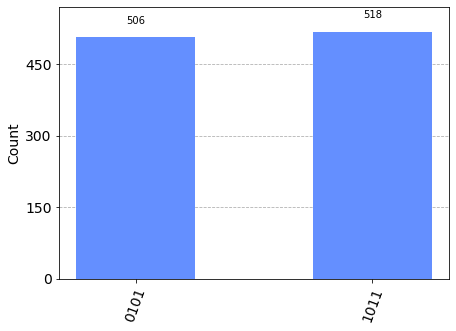

In [7]:
# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [8]:
measured_str = max(hist, key=hist.get)

In [9]:
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 11


In [10]:
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 4.31969


In [11]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 4.9


In [12]:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 2.48
